# Twitter Sentiment Analysis

The goal of this notebook is to visualize the sentiment of a target user's tweets.

To do so, we perform sentiment analysis of its tweets with CamemBERT, "a state-of-the-art language model for French based on the RoBERTa architecture pretrained on the French subcorpus of the newly available multilingual corpus OSCAR".

We first train the CamemBERT model on a dataset comprised of 5 000 labeled English tweets that have been translated to French via Google Translate. We then apply our model to the 100 latest tweets of a desired user, here @lemondefr.

This gives us a graph of @lemondefr's sentiment over its 100 latest tweets. Finally, by doing a frequency word count, we are able to fetch @lemondefr's top 20 words by usage, and visualize its most positive and negative tweets.

# Preliminary steps

In [ ]:
# Install machine learning librairies
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install keras
%pip install torch
%pip install tqdm
%pip install transformers
%pip install sentencepiece

# Twint requirements
%pip install twint
%pip install aiohttp
%pip install aiodns
%pip install beautifulsoup4
%pip install cchardet
%pip install dataclasses
%pip install elasticsearch
%pip install pysocks
%pip install pandas
%pip install aiohttp_socks
%pip install schedule
%pip install geopy
%pip install fake-useragent
%pip install googletransx
%pip install nest_asyncio

# Install data viz librairies
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install wordcloud

In [ ]:
# Import machine learning libraries
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer, CamembertForSequenceClassification, AdamW

# Import librairies for twitter scraping
import twint
import nest_asyncio
nest_asyncio.apply()  # Prevents some errors from running twint in kaggle, google collab or a jupyter notebook 

# Import librairies for data viz
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

In [ ]:
# Define constants
epochs = 5
MAX_LEN = 128  # Maximum number of words for the inputs
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Load the dataset. I only selected 5000 tweets because the model doesn't improve significatively with more tweets (1.2%
# increase in accuracy) but takes twice as much time to train
df = pd.read_csv('french_tweets.csv').sample(5000).reset_index(drop=True)
df.head()

,label,text
0,1,Merci d'avoir recherché cela pour moi
1,0,"Ew, j'ai le pire mal de tête et je sens la nau..."
2,1,Pas vraiment lol. La dernière fois c'est quand...
3,0,Je l'aime déjà. Je ne le vois pas sur DVD n'im...
4,1,"J'espère que vous répondez, j'ai essayé et ess..."


# Preprocessing the data

In [ ]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

In [ ]:
# Create list of texts and labels
text = df['text'].to_list()
labels = df['label'].to_list()

# Convert sentences into tokens
input_ids  = [tokenizer.encode(sent,add_special_tokens=True, truncation=True, max_length=MAX_LEN) for sent in text]

# Pad the input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]  
    attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels, train_masks,validation_masks = train_test_split(input_ids, labels, attention_masks,random_state=42, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of the data with torch DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Load CamemBERT

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=2)
model.to(device)

# Defining the parameters and metrics to optimize

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training and evaluating the model

In [ ]:
# Store the loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):  
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Add it to train loss list
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
    
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))


    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Validation of the model
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]
    
        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.5597857302385019


Epoch:  20%|██        | 1/5 [01:01<04:05, 61.40s/it]

Validation Accuracy: 0.885625
Train loss: 0.39413708284602944


Epoch:  40%|████      | 2/5 [02:02<03:03, 61.22s/it]

Validation Accuracy: 0.90125
Train loss: 0.27692289470780823


Epoch:  60%|██████    | 3/5 [03:02<02:02, 61.06s/it]

Validation Accuracy: 0.911484375
Train loss: 0.17756485847875159


Epoch:  80%|████████  | 4/5 [04:03<01:00, 60.98s/it]

Validation Accuracy: 0.925859375
Train loss: 0.12060917844229661


Epoch: 100%|██████████| 5/5 [05:04<00:00, 60.87s/it]

Validation Accuracy: 0.9278125


# Scraping tweets

In [ ]:
# Scraping tweets from a twitter user
def scrape_tweets(user):
    c = twint.Config()
    c.Username = user
    c.Since = '2021-07-01'
    c.Limit = 100
    c.Count = True
    c.Hide_output = True
    c.Store_csv = True
    c.Output = '../working/' + user + '_tweets.csv'
    twint.run.Search(c)

user = 'lemondefr'
scrape_tweets(user)
    

# Extracting the tweets from the csv
df = pd.read_csv('../working/' + user + '_tweets.csv')
user_tweets = []
for i in range(len(df['tweet'])):
    if df['language'][i] == 'fr':
        user_tweets.append(df['tweet'][i])

[+] Finished: Successfully collected 100 Tweets from @lemondefr.


# Evaluating the scraped tweets

In [ ]:
# Encode the comments
tokenized_comments_ids = [tokenizer.encode(comment, add_special_tokens=True, truncation=True,
                                           max_length=MAX_LEN) for comment in user_tweets]

# Pad the resulted encoded comments
tokenized_comments_ids = pad_sequences(tokenized_comments_ids, maxlen=MAX_LEN, dtype="long",
                                            truncating="post", padding="post")

# Create attention masks
attention_masks = []
for seq in tokenized_comments_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(tokenized_comments_ids)
prediction_masks = torch.tensor(attention_masks)

In [ ]:
# Apply the finetuned model
flat_pred = []
with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs =  model(prediction_inputs.to(device),token_type_ids=None, 
                      attention_mask=prediction_masks.to(device))
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    selected_indices = np.argmax(logits, axis=1)
    n = len(logits)
    selected_values = np.zeros((1, n))
    selected_values = selected_values[0]
    for i in range(n):
        if selected_indices[i] == 1:  # If the sentiment is positive
            selected_values[i] = logits[i][selected_indices[i]]
        else:
            selected_values[i] = -logits[i][selected_indices[i]]
    flat_pred.extend(selected_values)
    rescaled_pred = (flat_pred-np.mean(flat_pred))/(2*np.std(flat_pred)) + 0.5

# Sentiment Graph

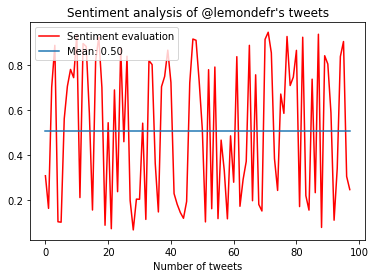

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot
x = np.array([i for i in range(len(rescaled_pred))])
y = np.array(rescaled_pred)
mean = np.mean(rescaled_pred)
mean_list = [mean for i in range(len(rescaled_pred))]
plt.plot(x, y, label = 'Sentiment evaluation', color = 'r')
plt.plot(x, mean_list, label = 'Mean: ' + str(mean)[:4])
plt.title('Sentiment analysis of @' + user + '\'s tweets')
plt.xlabel('Number of tweets')
plt.legend()
plt.show()
plt.savefig('plot.png')

# Word Frequency Graph

In [ ]:
# Processing tweets to remove any unnecessary character

# Keeping the original version of tweets intact in df
data = df.copy()
tweets = data['tweet'].to_list()

# Remove urls
tweets = [re.sub(r'http\S+', '', tweet) for tweet in tweets]

# Remove punctuation
tweets = [re.sub(r'[^\w\s]', ' ', tweet) for tweet in tweets]

# Remove numeric characters
tweets = [re.sub(r'[\d-]', '', tweet) for tweet in tweets]

# Convert all elements in lowercase
tweets = [tweet.lower().split() for tweet in tweets]

# Flatten tweets
words_list = [item for sublist in tweets for item in sublist]

# Removing words with less than 2 characters
words_list = [word for word in words_list if len(word) > 1]

# Remove stopwords
nltk.download("stopwords")
stopwords = stopwords.words("french")
words_list = [word for word in words_list if word not in stopwords]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 120287 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 120284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 120297 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 120280 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 120287 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 120284 missing from current font.
  font.

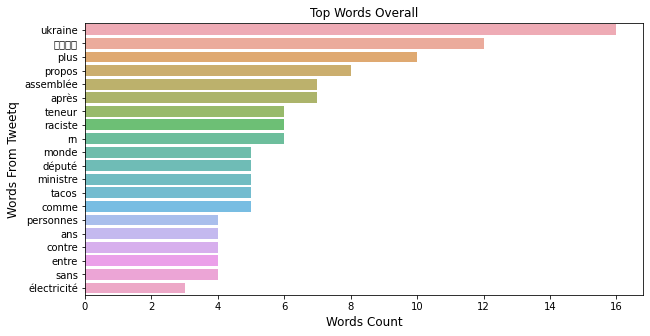

In [ ]:
# Word frequency counts
words_count = pd.DataFrame(words_list)
words_count = words_count[0].value_counts()

# Plot
words_count = words_count[:20,]
plt.figure(figsize=(10,5))
sns.barplot(words_count.values, words_count.index, alpha=0.8)
plt.title("Top Words Overall")
plt.ylabel("Words From Tweetq", fontsize=12)
plt.xlabel("Words Count", fontsize=12)
plt.show()

# Fetching the most positive and negative tweets

In [ ]:
# Constructing the positive and negative lists of tweets and predictions
positive_tweets = [user_tweets[i] for i in range(len(user_tweets)) if rescaled_pred[i] > 0.5]
positive_pred = [rescaled_pred[i] for i in range(len(user_tweets)) if rescaled_pred[i] > 0.5]
negative_tweets = [user_tweets[i] for i in range(len(user_tweets)) if rescaled_pred[i] < 0.5]
negative_pred = [rescaled_pred[i] for i in range(len(user_tweets)) if rescaled_pred[i] < 0.5]


top_3_positive = sorted(zip(positive_pred, positive_tweets), reverse=True)[:3]
top_3_negative = sorted(zip(negative_pred, negative_tweets))[:3]

print("Top 3 positive tweets :")
for pred, tweet in top_3_positive:
    print(tweet)

print("")
print("Top 3 negative tweets :")
for pred, tweet in top_3_negative:
    print(tweet)

Top 3 positive tweets :
« Y a de l’émotion, de la puissance, des déguisements, c’est cool ! » : un air de famille à l’Opéra de Paris, avec l’initiative Ma première fois à l’Opéra | par @sylviekerviel  https://t.co/mBeyONeVaT
Tortillas de maïs, tacos du berger ou tacos aux haricots et au fromage : trois recettes pour faire comme au Mexique | par @leopajon  https://t.co/2vMVM3APAu
Avec Walter Van Beirendonck, rendez-vous en… 3023 | par @valentinperezvp  https://t.co/CLTWfQM2rA

Top 3 negative tweets :
L’or, une valeur refuge qui perd de son éclat. Son cours a perdu plus de 10 % depuis le début de l’année.  https://t.co/GTedkK8a1T
Au Kenya, plus de 200 éléphants morts en 9 mois à cause de la sécheresse  https://t.co/suhG5A6z6p
Séance interrompue à l’Assemblée nationale après des propos à teneur raciste d’un député RN ; Emmanuel Macron s’est dit « heurté » par des propos « intolérables »  https://t.co/WQ5FBF8Yz5


# Generating the WordCloud

In [ ]:
# Preprocessing tweets to remove any unnecessary character

# Keeping the original version of tweets intact
preprocessed_positive_tweets = positive_tweets.copy()
preprocessed_negative_tweets = negative_tweets.copy()

# Remove urls
preprocessed_positive_tweets = [re.sub(r'http\S+', '', tweet) for tweet in preprocessed_positive_tweets]
preprocessed_negative_tweets = [re.sub(r'http\S+', '', tweet) for tweet in preprocessed_negative_tweets]

# Remove punctuation
preprocessed_positive_tweets = [re.sub(r'[^\w\s]', ' ', tweet) for tweet in preprocessed_positive_tweets]
preprocessed_negative_tweets = [re.sub(r'[^\w\s]', ' ', tweet) for tweet in preprocessed_negative_tweets]

# Remove numeric characters
preprocessed_positive_tweets = [re.sub(r'[\d-]', '', tweet) for tweet in preprocessed_positive_tweets]
preprocessed_negative_tweets = [re.sub(r'[\d-]', '', tweet) for tweet in preprocessed_negative_tweets]

# Convert all elements in lowercase
preprocessed_positive_tweets = [tweet.lower().split() for tweet in preprocessed_positive_tweets]
preprocessed_negative_tweets = [tweet.lower().split() for tweet in preprocessed_negative_tweets]

# Flatten tweets
preprocessed_positive_tweets = [item for sublist in preprocessed_positive_tweets for item in sublist]
preprocessed_negative_tweets = [item for sublist in preprocessed_negative_tweets for item in sublist]

# Removing words with less than 2 characters
preprocessed_positive_tweets = [word for word in preprocessed_positive_tweets if len(word) > 1]
preprocessed_negative_tweets = [word for word in preprocessed_negative_tweets if len(word) > 1]

# Remove stopwords
nltk.download("stopwords")
stopwords = stopwords.words("french")
preprocessed_positive_tweets = [word for word in preprocessed_positive_tweets if word not in stopwords]
preprocessed_negative_tweets = [word for word in preprocessed_negative_tweets if word not in stopwords]


# Converting into one only string
positive_string = " ".join(preprocessed_positive_tweets)
negative_string = " ".join(preprocessed_negative_tweets)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


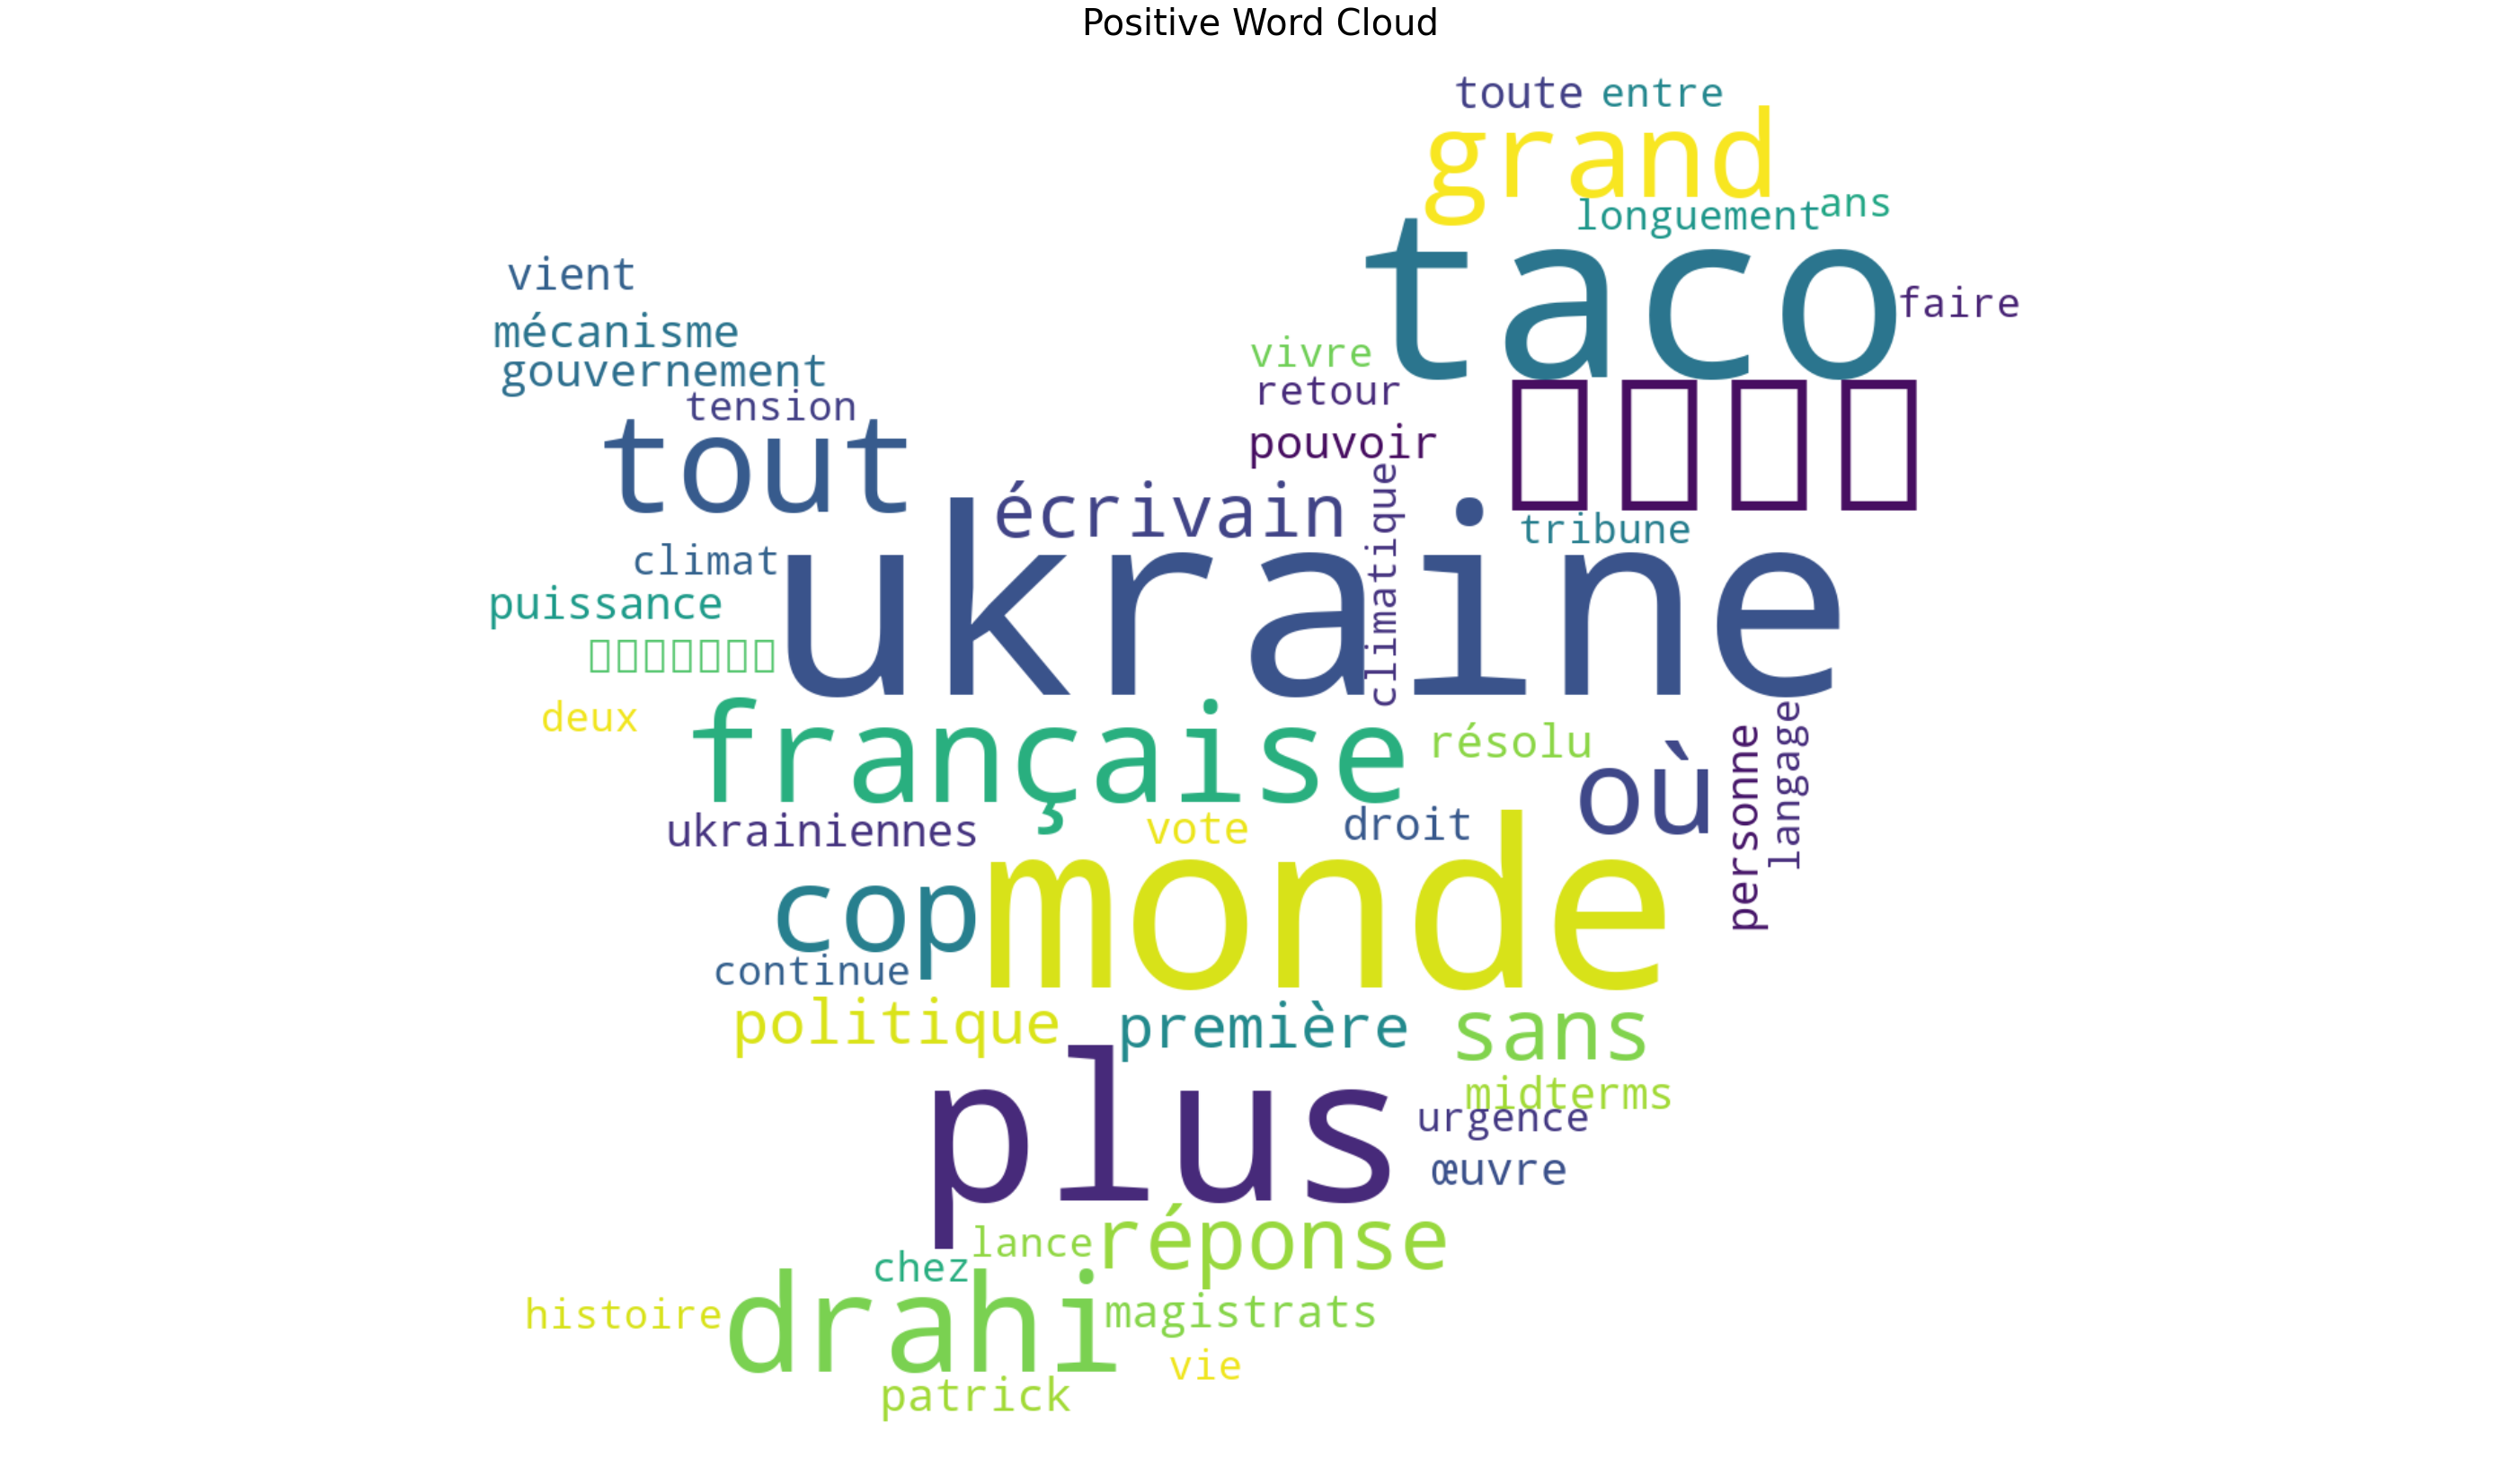

In [ ]:
# Plot positive words
mask = np.array(Image.open('../input/twitterlogo/twitter-logo.jpg'))
wordcloud = WordCloud(width = 1600, background_color = "white", mask = mask, height = 800, max_font_size = 200,
                      max_words = 50, collocations = False).generate(positive_string)

f = plt.figure(figsize=(50,50))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Word Cloud', size=40)
plt.axis("off")
plt.show()

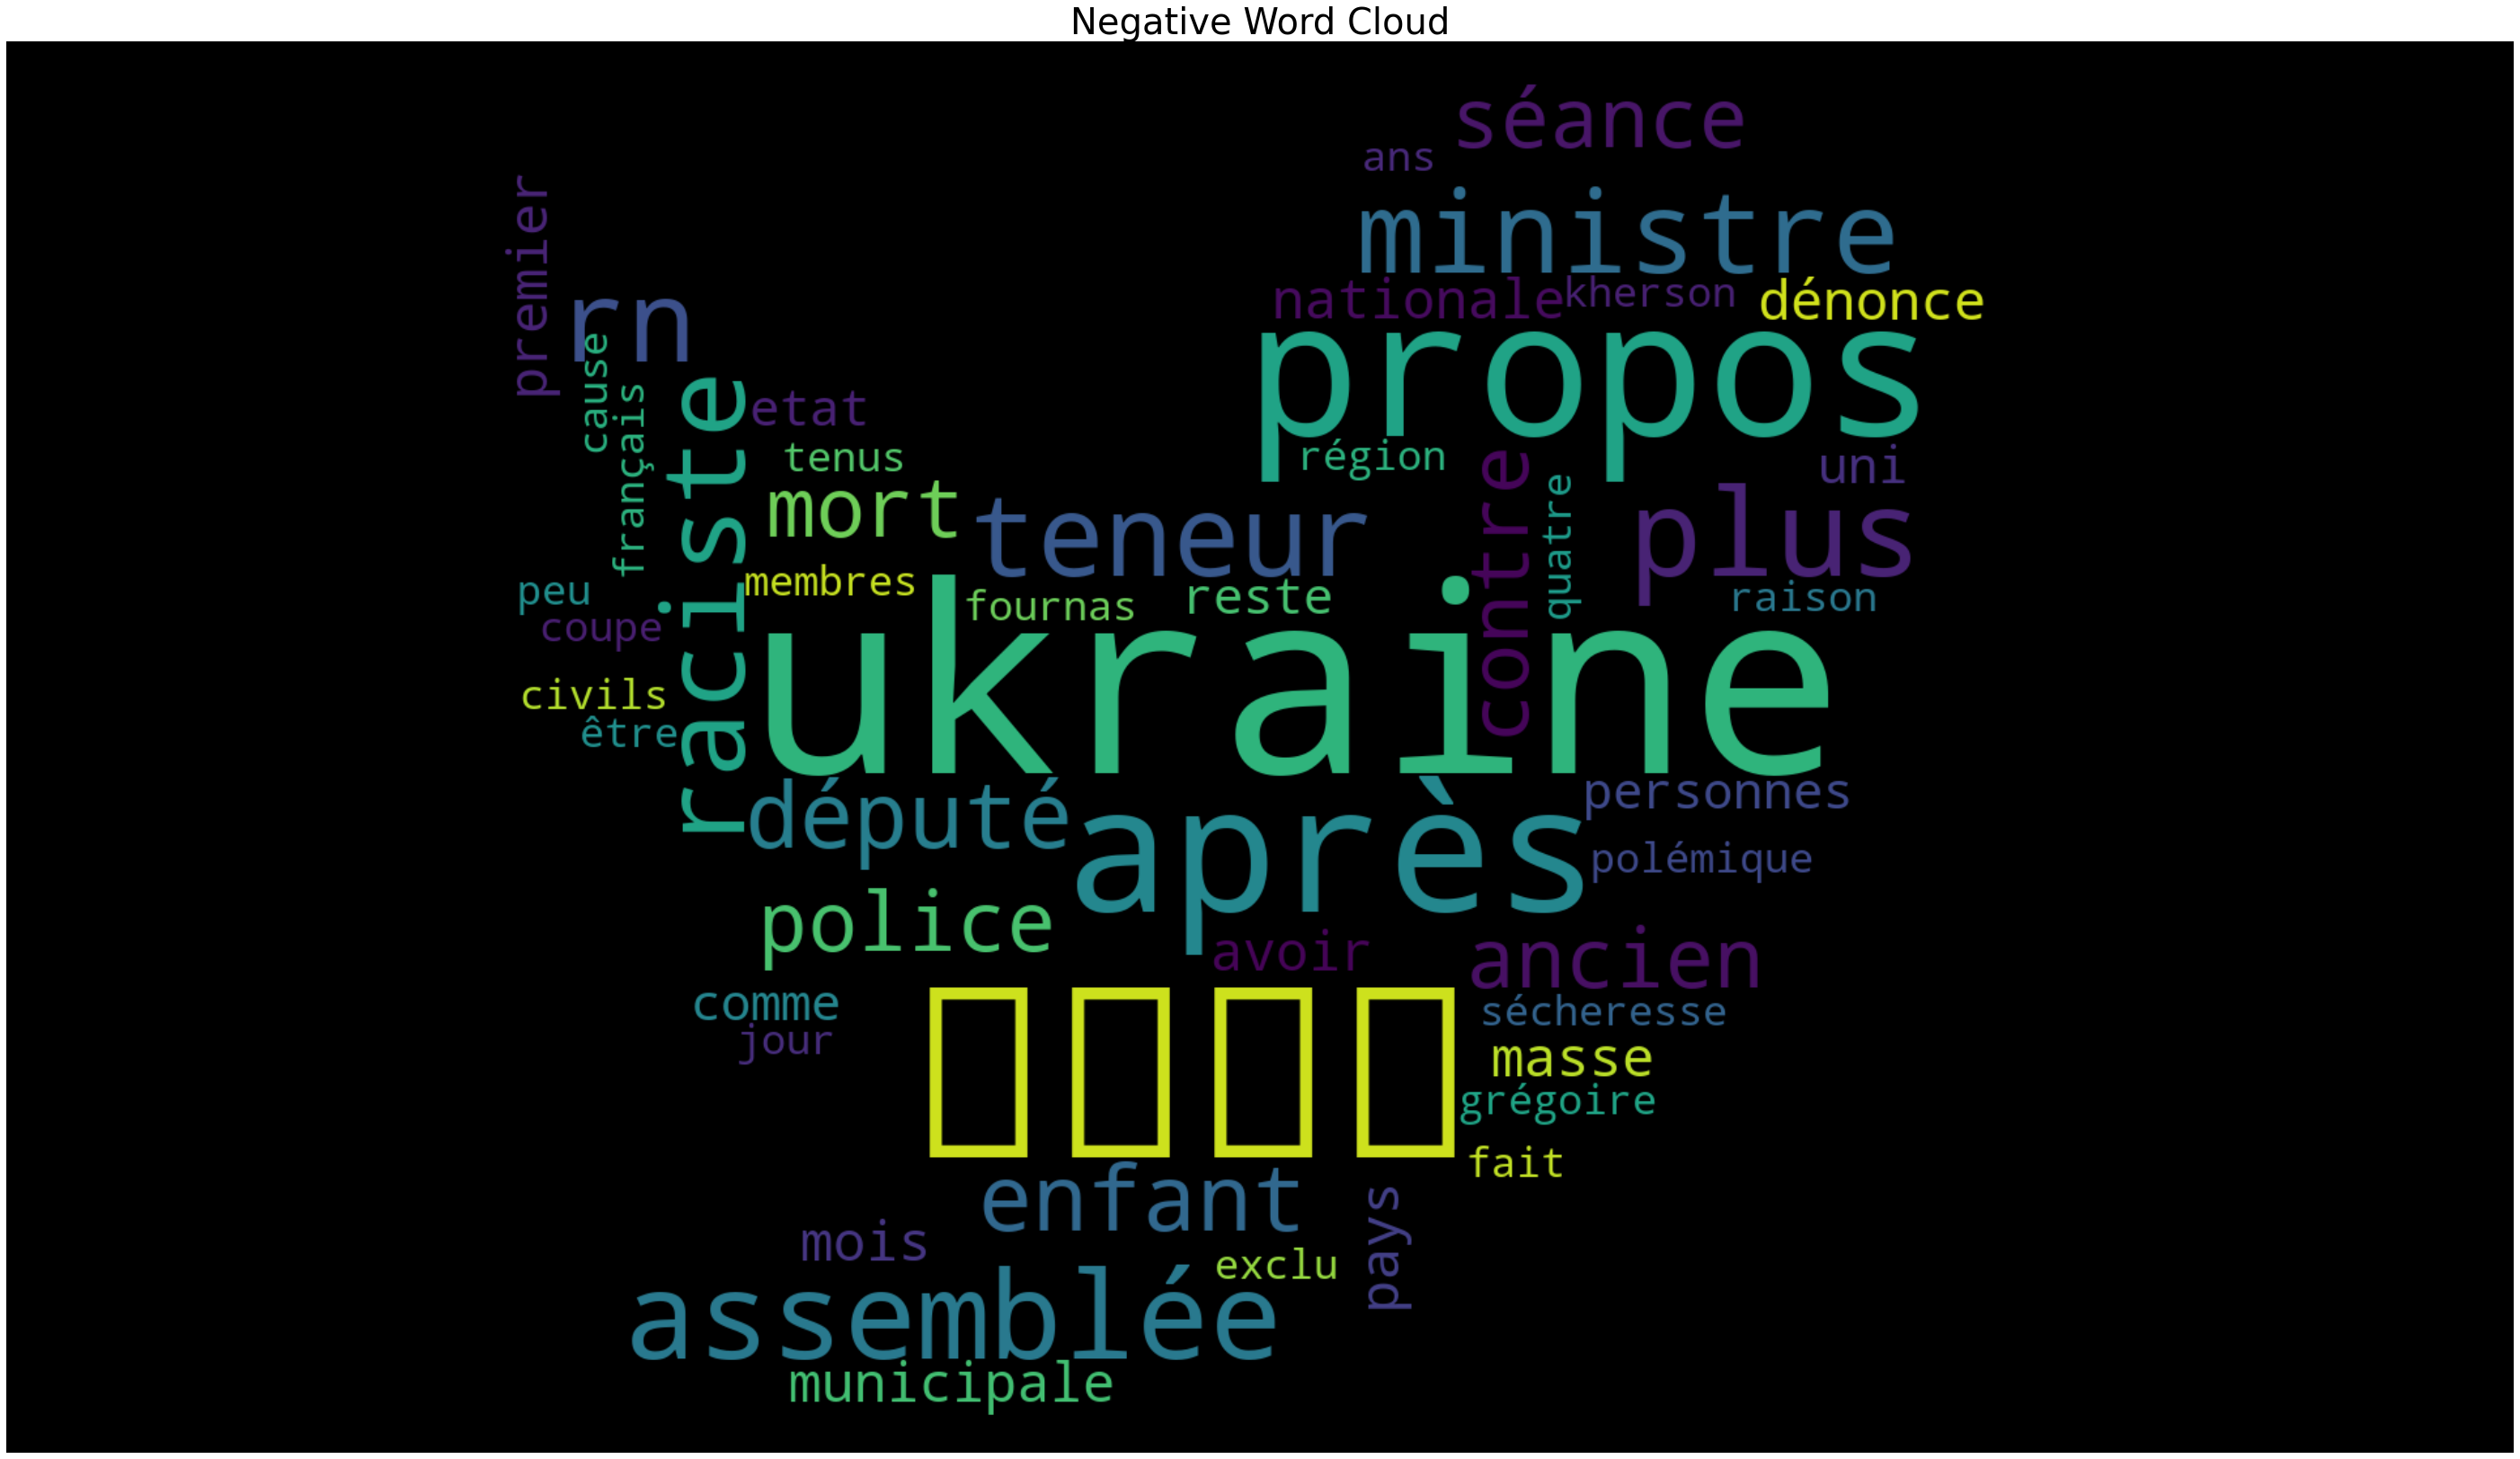

In [ ]:
# Plot negative words
mask = np.array(Image.open('../input/twitterlogo/twitter-logo.jpg'))
wordcloud = WordCloud(width = 1600, mask = mask, height = 800, max_font_size = 200,
                      max_words = 50, collocations = False).generate(negative_string)

f = plt.figure(figsize=(50,50))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative Word Cloud', size=40)
plt.axis("off")
plt.show()